Ajuste usando minimos cuadrados
b,m =  
0.07289 x + 1.662



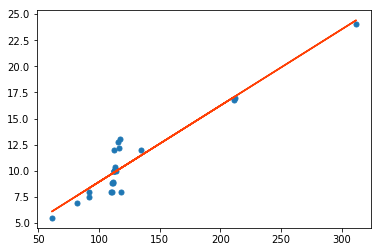

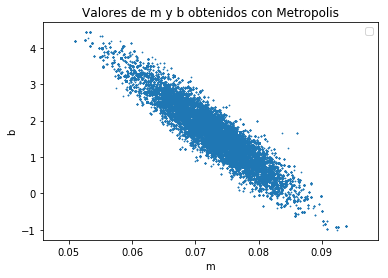

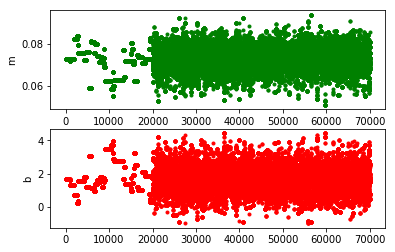

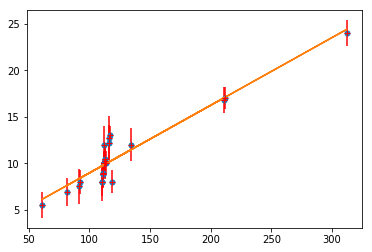

In [13]:
import random #números aleatorios
import math #funciones matematicas estandar.
from matplotlib import pyplot as plt #Para visualizaciones y gráficos.
import numpy as np #funciones estadísticas 
import seaborn as sns # para realizar gráficos estadísticos.
from mpl_toolkits.mplot3d import axes3d #graficas en 3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 
#datos
datos = np.array([[110,8,1,1.5],[111.5,8.85,1.2,1.4],[111,8.8,1.5,1.3],[112,10,1.6,1.3],[114,10,1.3,1.3],[91.4,7.5,1.1,1.9],
                  [61,5.5,1.3,1.4],[112,12,1.8,2.0],[112,10,2.5,1.2],[112.5,10,1.6,1.7],[312,24,1.5,1.4],[212,17,1.3,1.2],
                  [117,13,1.1,1.0],[116.5,12.2,1.6,1.9],[118.25,8,1.21,1.24],[134.35,12,1.7,1.8],[91.8,8,2,1.3],[110.5,8,1.1,2.1],
                  [211.05,16.8,1.0,1.4],[112.8,10.2,1.3,1.8],[115.9,12.72,1.9,2.4],[113,10.4,1.8,1.3],[112,10,1.9,1.1],
                  [111.1,8.9,1.5,1.6],[81.5,6.9,1.5,1.5]])

# Valores m y b inicio
m = 10
b = 20
# Cadenas
ncad = 7 
steps = 10000
# Posiciones
x = datos[:,0]
y = datos[:,1]
# Fit 1 para fit linear 
y1 = np.polyfit(x, y, 1) 
parame= np.poly1d(y1)
# Tamaño de los pasos (sigmas)
pasom = 1
pasob = 1

# Datos x, y, errorx, errory 
def data():
    x = datos[:,0]
    y = datos[:,1]
    errox = datos[:,2]
    erroy = datos[:,3]
    return (x, y, errox, erroy)

# Funcion para graficar las barras de error de los datos
def ploterry(x, y, errox, erroy):
    plt.errorbar(x, y, yerr=erroy, fmt='+', color='r')
     
# Modelo 
def plot_line(b, m, **kwargs):
    p = plt.plot(x, parame(x), 'r', alpha=0.5, **kwargs)
    plt.show()
    return p

def leastsq(x, y):
    print 'Ajuste usando minimos cuadrados'
    y1 = np.polyfit(x, y, 1) # se usara la funcion fit por facilidad, el 1 al final denota un fit linear 
    parame= np.poly1d(y1)  #Crea un polinomio, es decir proveniente del fit  
    plt.plot(x,y,'o', markersize=5)  # grafica los puntos de los datos 
    plt.plot(x, parame(x)) # grafica el fit
    print 'b,m =', parame
    (m, b) = parame
    print
    return (m, b)

# analisis de datos
(x, y, errox, erroy) = data() 

# Solucion de m y b con minimos cuadrados ignorando el error de y.
(m, b) = leastsq(x, y)
plot_line(m, b)
plt.title('Ajuste por minimos cuadrados')
print

# Definimos la funcion likehood gaussiana para una linea
def likelihood(x, y, erroy, m, b):
    return np.prod(1./(np.sqrt(2.*np.pi) * erroy) * np.exp(-(y - (m * x + b))**2 / (2. * erroy**2)))

# Definimos el prior
def prior(m,b):
    if ((0 < m <25) and (-1 < b < 50)):
        return 0.
    else:
        return -np.infty
    return  


#  Guardan m,b de n pasos
chain = []
probs = []

for j in range(ncad):
    if (j==0): 
        # Si es la primera cadena iniciamos con m y b definidos arriba
        minicial = m
        binicial = b
    elif (j==1):
        # Despues de haber hecho una cadena obtenemos los mejores valores de m y b con la probabilidad maxima
        mm = [m for m,b in chain]
        bb = [b for m,b in chain]
        
        # Obteniendo los mejores valores de m, b cnon la probabilidad
        besti = np.argmax(probs)
        bestm = mm[besti]
        bestb = bb[besti]
        
        # Despues de la primera cadena redefinimos los sigmas con la desviacione standar de la primera cadena 
        # y obtenemos valores random normales para m y b
    elif (j>=1):
        pasom = 2*np.std(mm)
        pasob = 2*np.std(bb)
        minicial = np.random.normal(bestm,pasom)
        binicial = np.random.normal(bestb,pasom)
        
    for i in range(steps):
        # Obteniendo un valor aleatorio normalizado de m y b
        mnue = np.random.normal(minicial,pasom)
        bnue = np.random.normal(binicial,pasob)
        
        # Evaluando la probabilidad con los nuevos m y b
        nueprob = likelihood(x, y, erroy, mnue, bnue)
        # Evaluando probabilidad de m y b iniciales
        vieprob = likelihood(x, y, erroy, minicial, binicial)
        
        lnprior = prior(mnue,bnue) # Obteniendo valor de prior para los m y b nuevos
        
        # Realizamos un primer filtro de los datos poner un pr igual a lo que viene del prior 
        # y en donde calculo prob_new  igual al prob_new mas el prior
        # checar que si el prior es infinito entonces se salga
        if (lnprior == 0.):
            nueprob = nueprob 
        else:
            nueprob = nueprob + lnprior
            
        # Comparando las probabilidades para decidir cuales valores de m aceptar 
        if (nueprob/vieprob > 1):
            minicial = mnue
            binicial = bnue
            prob = nueprob
        else:
            probtest = np.random.uniform(0,1)
            if (probtest> nueprob/vieprob):
                prob = vieprob
            else:
                minicial = mnue
                binicial = bnue
                prob = nueprob
                
        # Guardando los valores de m y b
        chain.append((minicial,binicial))
        # Guardando el valor de la probabilidad (likehood)
        probs.append(prob)

        # Estos vectores contienen todos los m y b de todas las cadenas
mm = [m for m,b in chain]
bb = [b for m,b in chain]

# Obteniendo los mejores valores de m, b cnon la probabilidad
#besti = np.argmax(probs)
#bestm = mm[besti]
#bestb = bb[besti]

# Graficando los valores de m y b
plt.scatter(mm, bb, s=3, lw = 0)
# Mejor valor obtenido de m y b
plt.plot(label='Best m,b',markersize=5, markerfacecolor='r') #plt.plot(bestm, bestb, 'ko', label='Best m,b',markersize=5, markerfacecolor='r')
plt.xlabel('m')
plt.ylabel('b')
plt.title('Valores de m y b obtenidos con Metropolis')
plt.legend()
plt.show()

plt.clf()
plt.title('Graficas de muestreo para las cadenas consecutivas')
plt.subplot(2,1,1)
plt.plot(mm, 'g.')
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'r.')
plt.ylabel('b')
plt.show()


ploterry(x, y, errox, erroy)
y1 = np.polyfit(x, y, 1) # se usara la funcion fit por facilidad, el 1 al final denota un fit linear 
beta = np.poly1d(y1)  #Crea un polinomio, es decir proveniente del fit  
 
plt.plot(x,y,'o', markersize=5)  # grafica los puntos de los datos 
plt.plot(x, beta(x)) # grafica el fit

#Al parecer la version de Python no permite importar la libreria pyramid o triangle y hacer las graficas en 3D.